**Machine Learning for Time Series (Master MVA)**

- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

# Introduction

In this tutorial, we will explore several techniques for **signal modeling and denoising**.
In particular, we will cover the following topics:

- modeling a signal into trend, seasonality, and stationary components,
- denoising a signal using standard filtering techniques,
- predicting signals through parametric models,
- autoregressive (AR) and moving average (MA) processes,
- singular spectrum analysis (SSA).

## Setup

**Imports**

In [ ]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import neurokit2 as nk

import IPython.display as ipd
from scipy.signal import medfilt
from numpy.fft import rfft, rfftfreq
from numpy.polynomial.polynomial import Polynomial
from scipy.cluster import hierarchy
from scipy.signal import butter, filtfilt
from scipy.signal import argrelmax, periodogram
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import acf, adfuller, kpss, pacf

**Utility functions**

In [ ]:
try:
    from numpy.lib.stride_tricks import sliding_window_view  # New in version 1.20.0

    def get_trajectory_matrix(arr, window_shape, jump=1):
        return sliding_window_view(x=arr, window_shape=window_shape)[::jump]

except ImportError:

    def get_trajectory_matrix(arr, window_shape, jump=1):
        n_rows = ((arr.size - window_shape) // jump) + 1
        n = arr.strides[0]
        return np.lib.stride_tricks.as_strided(
            arr, shape=(n_rows, window_shape), strides=(jump * n, n)
        )
    
def fig_ax(figsize=(15, 4)):
    return plt.subplots(figsize=figsize)

def get_largest_local_max(
    signal1D: np.ndarray, n_largest: int = 3, order: int = 1
) -> [np.ndarray, np.ndarray]:
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_indexes = all_local_max_indexes[all_local_max.argsort()[::-1]][
        :n_largest
    ]

    return (
        np.take(signal1D, largest_local_max_indexes),
        largest_local_max_indexes,
    )

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

def average_anti_diag(traj_matrix: np.ndarray) -> np.ndarray:
    """Average anti diagonal elements of a 2d array"""
    x1d = [
        np.mean(traj_matrix[::-1, :].diagonal(i))
        for i in range(-traj_matrix.shape[0] + 1, traj_matrix.shape[1])
    ]
    return np.array(x1d)

# Signal representation

In the first section of this tutorial, we will see how signal modeling can be used to create compact and efficient representations of time series data.

We will begin with a brief review of the concepts of aliasing and spectral leakage.

### Aliasing

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Generate four pure sine waves with the following frequencies: 261.63 Hz, 43838.37 Hz, 196 Hz, and 43904 Hz. 
    Set the duration to 3 seconds and the sampling frequency to 44.1 kHz.</p>
    <p>Listen to the signal. What do you observe? Explain your observation.</p>
    <p>Then, repeat the same experiment using a sampling frequency of 88.2 kHz.</p>
    <p>How does increasing the sampling rate affect the signal you hear ?</p>
</div>


In [ ]:
T = ...
fs= ...
t= ... 
frequencies=[...]
signals=[...]

In [ ]:
for i,f in enumerate(frequencies):
    display(ipd.Audio(signals[i], rate=44100))
    print(f"Played frequency: {f} Hz")

### Spectral leakage

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Compute and display the DFT of a pure sine wave of frequency f=1.5 Hz.
    Set the duration to 3 seconds and the sampling frequency to 5 Hz.</p>
    </p>What is the expected DFT shape? What do you observe? How to cope with this phenomenon ?</p>
</div>

In [ ]:
fs = ...
T = ...
t = ...
f = ...

## Data 

The ecg_simulate function from the neurkit2 library allows generating an artificial ECG signal of a specified duration and sampling rate, using either the ECGSYN dynamical model (McSharry et al., 2003), which accurately reproduces cardiac waveforms, or a simpler model based on Daubechies wavelets.


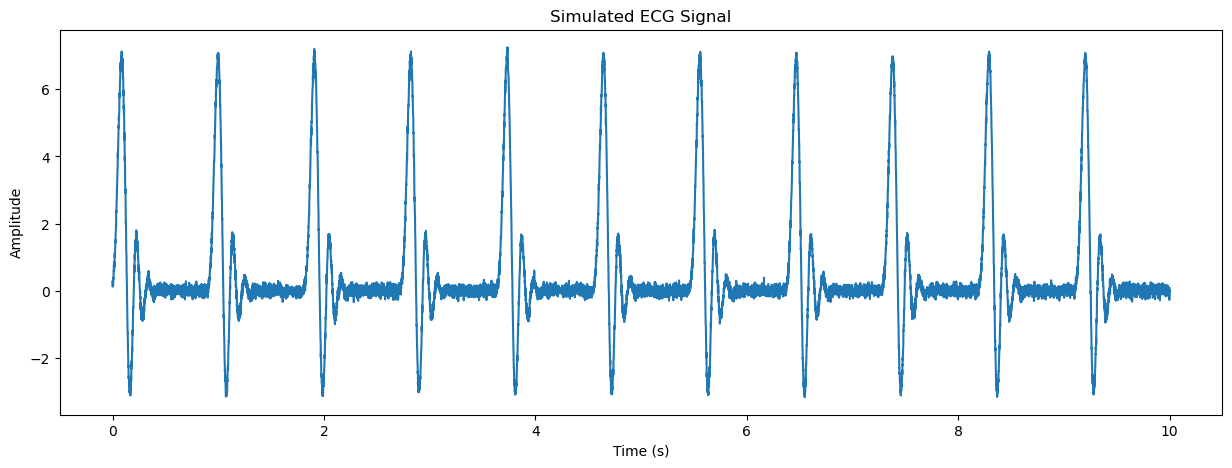

In [8]:
fs=1000
T= 10
times= np.linspace(0, T, T * fs, endpoint=False)
ecg_signal= nk.ecg_simulate(duration=T, sampling_rate=fs, method="simple", noise = 0)
gaussian_noise= np.random.normal(0, 0.1, ecg_signal.shape)
ecg_signal += gaussian_noise

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(times, ecg_signal)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Simulated ECG Signal")
plt.show()

### Denoising with filters

<div class="alert alert-success" role="alert">
  <p><b>Question</b></p>
  <p>
    Plot the <b>log-spectrum</b> of the signal.<br>
    From this plot:
    <ul>
      <li>Estimate the <b>noise amplitude</b>.</li>
      <li>Estimate a suitable <b>cutoff frequency</b> for denoising the signal.</li>
    </ul>
  </p>
</div>

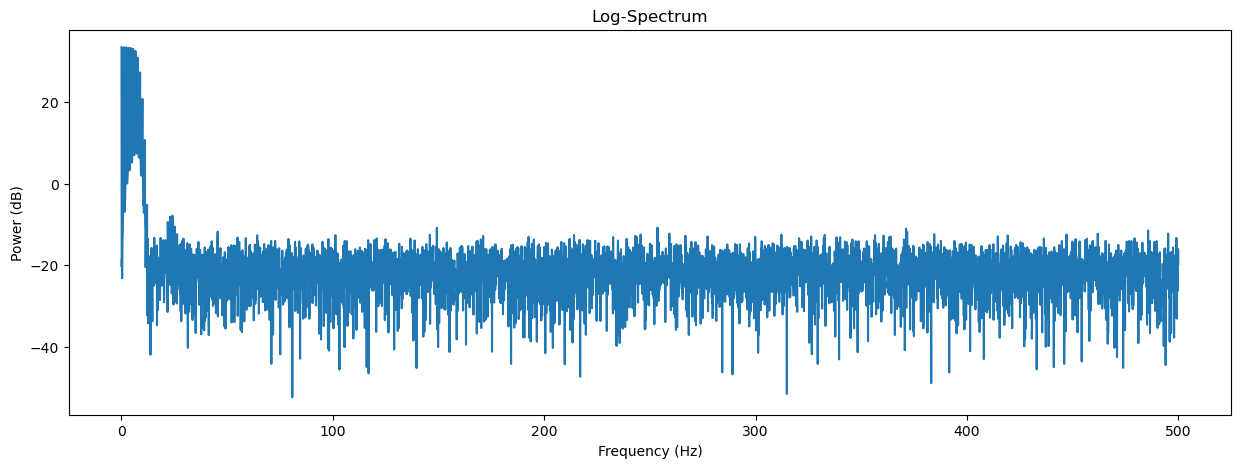

In [10]:
import numpy as np
import matplotlib.pyplot as plt

fft_vals = rfft(ecg_signal)
freqs = rfftfreq(n=len(ecg_signal), d=1/fs)

N = T * fs 

# Amplitude en dB
log_dft = 10 * np.log10(np.abs(fft_vals)**2 / N)

# Plot
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(freqs, log_dft)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power (dB)")
ax.set_title("Log-Spectrum")
plt.show()


In [9]:
fc = ... # Cutoff frequency in Hz
estimated_noise= ...

We can use a low-pass Butterworth filter to denoise the signal.

In [ ]:
from scipy.signal import butter, filtfilt

order = 4 # filter order

b, a = butter(order, fc , btype='low', analog=False, fs=fs)

# Apply the filter
filtered_signal = filtfilt(b, a, ecg_signal)

plt.figure(figsize=(12, 5))
plt.plot(times, ecg_signal, label="Original Signal", alpha=0.6)
plt.plot(times, filtered_signal, label="Filtered Signal (Butterworth low-pass)", linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("ECG Signal Denoising using Butterworth Low-Pass Filter : MSE = {:.4f}".format(np.mean((ecg_signal - filtered_signal)**2)))
plt.legend()
plt.show()

### Sinusoidal model

In this section, we aim to reconstruct this signal using a simplified sinusoidal model.

In [ ]:
fs=1000
T= 10
times= np.linspace(0, T, T * fs, endpoint=False)
ecg_signal= nk.ecg_simulate(duration=T, sampling_rate=fs, method="simple", noise=0.1)


fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(times, ecg_signal)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Simulated ECG Signal")
plt.show()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Compute and display the autocorrelation function of the signal.
    </p> Propose a method to estimate the fundamental frequency and apply it to the signal</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Using the function below, apply the sinusoidal model to the signal for several values of order (e.g., 1, 3, 5, 10):</p>
    <ul>
        <li>For each order, plot both the <b>original signal</b> and the <b>reconstructed signal</b> on the same graph.</li>
        <li>Compute and report the <b>mean squared error (MSE)</b> between the original and reconstructed signals for each order.</li>
        <li>Briefly discuss how the reconstruction quality changes as the order increases.</li>
    </ul>
</div>


In [ ]:
def sinusoidal_model(signal, timestamps, f0, order=2):
    """Fit a sinusoidal model to the signal."""
    X = np.column_stack(
        [np.sin(2 * np.pi * (i + 1) * f0 * timestamps) for i in range(order)]
        + [np.cos(2 * np.pi * (i + 1) * f0 * timestamps) for i in range(order)]
    )
    coefs= np.linalg.lstsq(X, signal, rcond=None)[0]
    fitted_signal = X @ coefs
    return coefs, fitted_signal

In [11]:
order_list= [1, 3, 5, 10]
for order in order_list:
    pass

### Trend + Seasonality model

In this section we aim to reconstruct a signal with a trend+seasonality model.

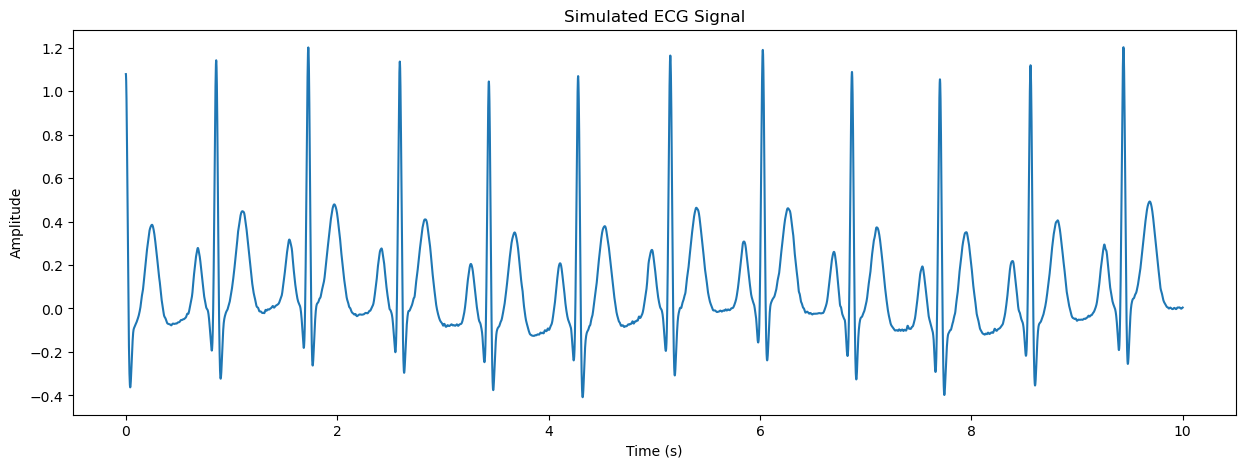

In [16]:
fs=1000
T= 10
times= np.linspace(0, T, T * fs, endpoint=False)
ecg_signal= nk.ecg_simulate(duration=T, sampling_rate=fs, method="ecgsyn")


fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(times, ecg_signal)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Simulated ECG Signal")
plt.show()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Estimate the fundamental frequency of the signal<p>
    <p>Using the function below, apply the trend+seasonality model to the signal for a fixed seasonality order of 10 and for several values of trend order (e.g., 0, 1, 2, 5, 10).<p> 
</div>

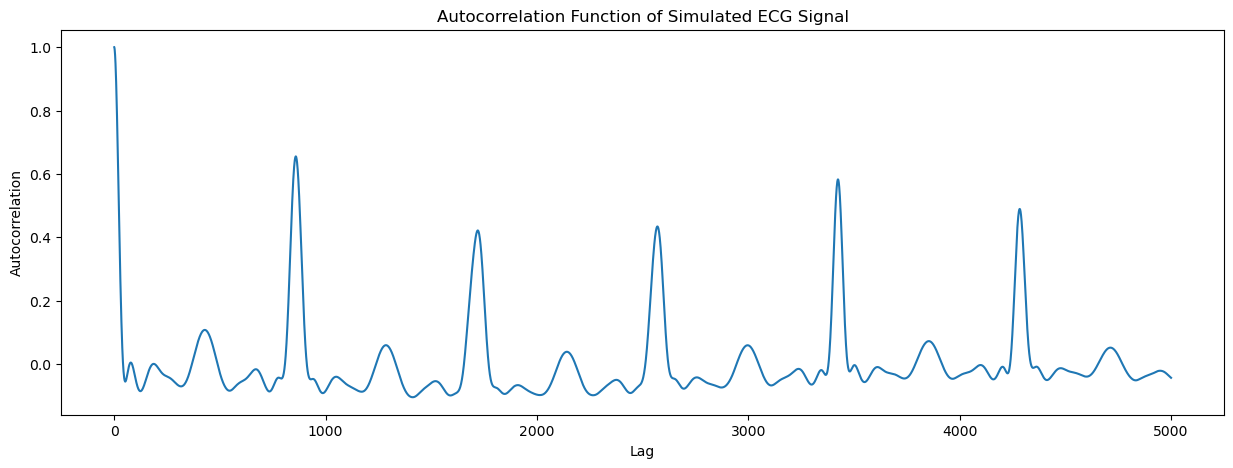

In [17]:
autocorr = acf(ecg_signal, nlags=fs*5)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(autocorr)
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function of Simulated ECG Signal")
plt.show()

In [18]:
_, m0 = get_largest_local_max(autocorr, n_largest=1, order=fs//2)
m0=m0[0]
f0= fs / m0
f0

1.1641443538998837

In [19]:
def trend_seasonality_model(signal, timestamps, f0, trend_order=2, seasonality_order=2):
    """Fit a trend + seasonality model to the signal."""
    seasonality = np.column_stack(
        [np.sin(2 * np.pi * (i + 1) * f0 * timestamps) for i in range(seasonality_order)]
        + [np.cos(2 * np.pi * (i + 1) * f0 * timestamps) for i in range(seasonality_order)]
    )
    trend = np.column_stack(
        [timestamps**i for i in range(trend_order + 1)]
    )

    X = np.column_stack((trend, seasonality))
    coefs = np.linalg.lstsq(X, signal, rcond=None)[0]
    fitted_signal = X @ coefs
    return coefs, fitted_signal

In [22]:
trend_order_list = [0, 1, 2, 5, 10]

for order in trend_order_list:
    pass

## Signal prediction

In this section, we will use signal modeling techniques to perform signal prediction.

## Data

In [23]:
X=pd.read_csv('nyc_taxi.csv')
X["timestamp"] = pd.to_datetime(X["timestamp"])

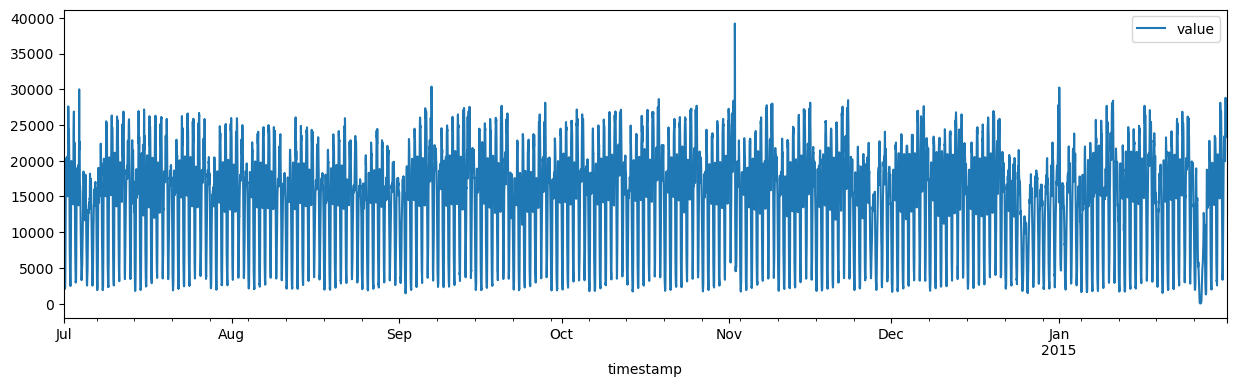

In [24]:
fig, ax = fig_ax()
_ = X.plot(x="timestamp", y="value", ax=ax)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot the taxi count for October and for the 2014-10-12.</p>
</div>

## Daily count

In this tutorial, we are interested in the evolution in the **daily** count.
To that end, we resample the original signal.

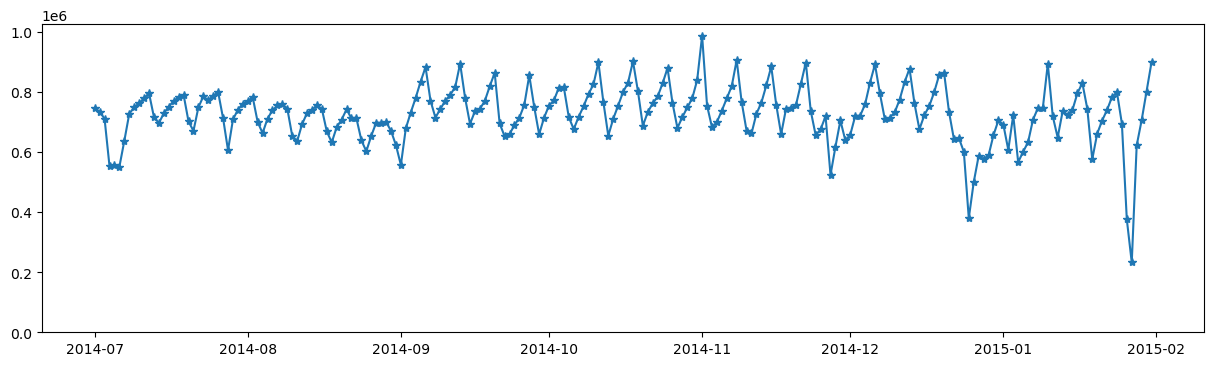

In [25]:
X["timestamp"] = pd.to_datetime(X["timestamp"])
daily_taxi_count = X.resample("1D", on="timestamp").sum()
daily_taxi_count_np = daily_taxi_count.to_numpy().squeeze()
fig, ax = fig_ax()
ax.plot(daily_taxi_count, "*-")
_ = ax.set_ylim(0)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot the daily count in October 2014. What can you observe?</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What are the important periodicities in the original signal?</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot or print the average count per hour of the day. Which time is the busiest?</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot or print the average count per day of the week. Which day is the busiest?</p>
</div>

# Signal Prediction

The objective is to predict the daily taxi for the next two weeks (14 days).
First, we prepare the training and testing data.

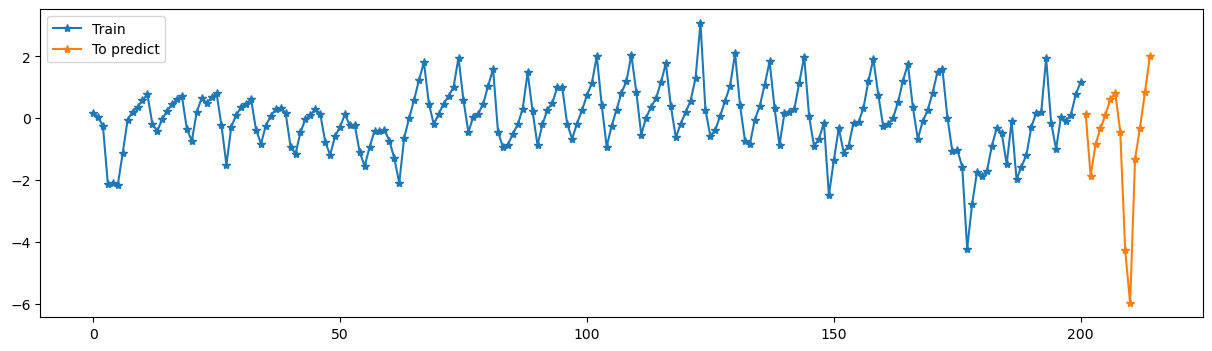

In [28]:
n_samples_pred = 14  # predict the next 14 samples

# train/test split
signal_train, signal_pred = np.split(
    daily_taxi_count_np.astype(float), [-n_samples_pred]
)
n_samples = n_samples_train = signal_train.size

# scaling
scaler = StandardScaler().fit(signal_train.reshape(-1, 1))
signal_train = scaler.transform(signal_train.reshape(-1, 1)).flatten()
signal_pred = scaler.transform(signal_pred.reshape(-1, 1)).flatten()

# keep the indexes of train and test (for plotting mostly)
time_array_train, time_array_pred = np.split(
    np.arange(daily_taxi_count_np.size), [-n_samples_pred]
)
time_array = time_array_train
calendar_time_array = daily_taxi_count.iloc[time_array].index.to_numpy()

# plot
fig, ax = fig_ax()
ax.plot(time_array_train, signal_train, "-*", label="Train")
ax.plot(time_array_pred, signal_pred, "-*", label="To predict")
_ = plt.legend()

## Trend

Three trend estimation methods are tested:

- constant trend,
- linear trend,
- polynomial trend.

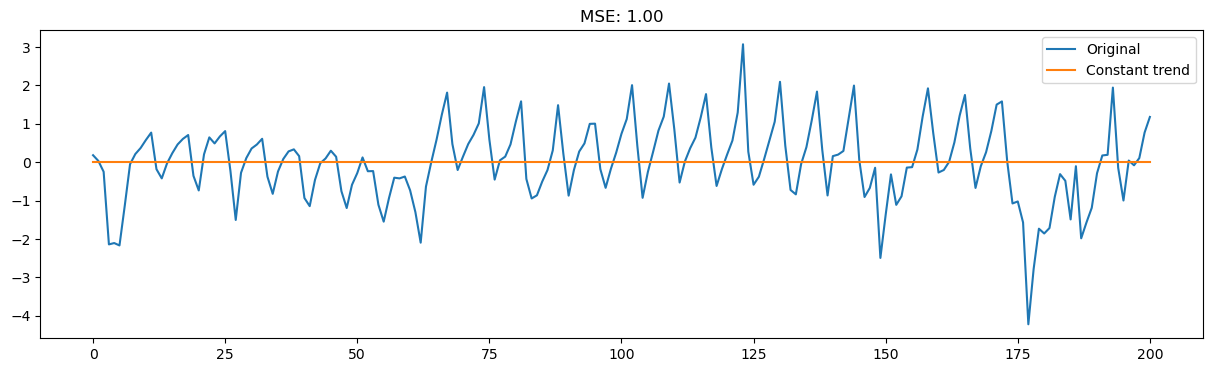

In [29]:
fig, ax = fig_ax()
ax.plot(signal_train, label="Original")

level = signal_train.mean()  # should be zero
approx_trend = level * np.ones(signal_train.size)
ax.plot(approx_trend, label="Constant trend")
ax.set_title(f"MSE: {(signal_train-approx_trend).var():.2f}")
_ = plt.legend()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot the best linear approximation and polynomial approximation (deg=13) of the signal (you may use <code>Polynomial.fit</code>). What are the associated MSE?</p>
</div>

In [30]:
for order in [1,13]:
    pass

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>In the previous cell, show the trend predicted by the polynomial fit in the next 14 samples. What do you conclude?</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>To conclude, which trend do you choose?</p>
</div>

## Seasonality

The seasonality is the periodical component in the signal at hand.

**Finding the harmonic frequencies.**

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Give two ways to estimate the presence of seasonalities.</p>
</div>


The DFT is not a consistent estimator of the power spectral density.
In practice, the periodogram (or any other variations) is prefered: the DTF is computed over several (possibly overlapping) windows and averaged.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What is the advantage of using the periodogram instead of the autocorrelation function to estimate the main periodicities in a signal?</p>
</div>


Estimated seasonality period: 7 samples


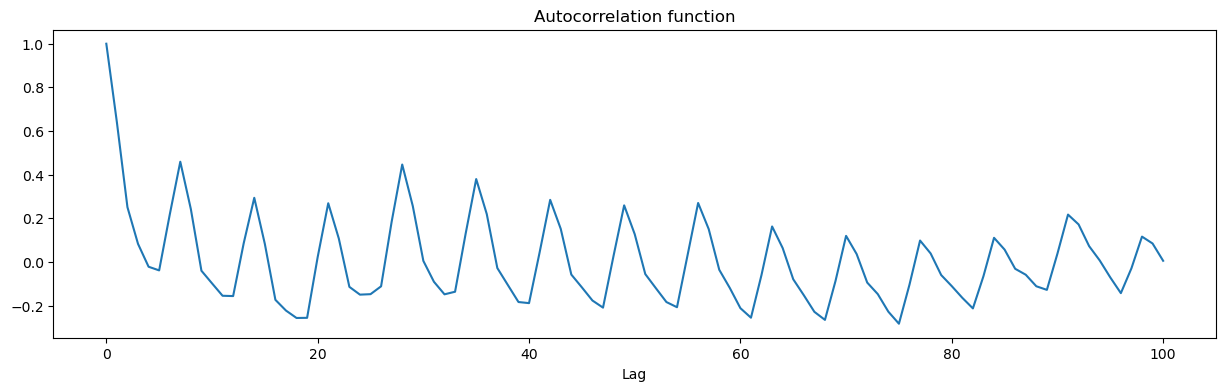

In [34]:
autocorr = acf(signal_train, nlags= n_samples_train//2)
fig, ax = fig_ax()
ax.plot(autocorr)
ax.set_title("Autocorrelation function")
_ = ax.set_xlabel("Lag")
_, m0 = get_largest_local_max(autocorr, n_largest=1, order=5)
m0=m0[0]
print(f"Estimated seasonality period: {m0} samples")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Using the periodogram, estimate the two main frequencies present in the signal.</p>
</div>


**Harmonic regression**

In an harmonic regression (with two harmonic components), the signal is modelled as follows:
$$
y_t = \mu + A_1\cos(2\pi f_1 t + \phi_1) + A_2\cos(2\pi f_2 t + \phi_2) + \epsilon_t
$$

where $\mu, A, \phi\in\mathbb{R}$ must be estimated, the frequencies $f_1$ and $f_2$ are given, and $\epsilon_t$ is a white noise.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How can you rewrite this problem as a linear regression problem?</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Code the harmonic regression with the two previously estimated frequencies and show the final fit, the residual signal and the MSE.</p>
</div>


In [35]:
def harmonic_regression(signal, timestamps, f1, f2):
    """Fit a harmonic regression model to the signal."""
    pass

In [36]:
coefs, fitted_train_signal = harmonic_regression(
    signal_train, time_array, f1=f1, f2=f2)

X_pred= np.column_stack((
    np.ones(time_array_pred.shape[0]),
    np.column_stack(
        [np.sin(2 * np.pi *  f1 * time_array_pred) ]
        + [np.cos(2 * np.pi  * f1 * time_array_pred) ]),
    np.column_stack(
        [np.sin(2 * np.pi *  f2 * time_array_pred) ]
        + [np.cos(2 * np.pi  * f2 * time_array_pred) ])  
))

fitted_pred_signal = X_pred @ coefs

fig,ax = fig_ax()
ax.plot(signal_train, label="Original")
ax.plot(fitted_train_signal, label="Fitted signal")
ax.plot(time_array_pred, signal_pred, "-*", label="To predict")
ax.plot(time_array_pred, fitted_test_signal, "r--", label="Predicted trend")
ax.legend()
ax.set_title(f"Test_MSE: {(signal_pred - fitted_pred_signal).var():.2f}")

NameError: name 'f1' is not defined

## Studying the residual signal

### A simulated example

Simulate a MA(2) process and an AR(2) process.
For each plot the autocorrelation and partial autocorrelation.

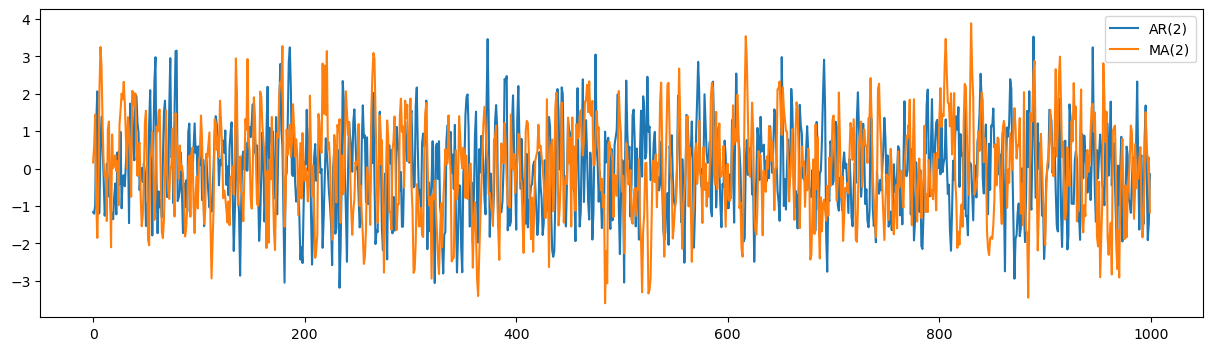

In [37]:
arparams = np.array([0.55, -0.25])  #
maparams = np.array([0.65, 0.35])

ar = np.r_[1, -arparams]  # add zero-lag and negate
ma = np.r_[1, maparams]  # add zero-lag


n_samples_simulated = 1000
ar2 = arma_generate_sample(ar, [1], n_samples_simulated)
ma2 = arma_generate_sample([1], ma, n_samples_simulated)

fig, ax = fig_ax()
ax.plot(ar2, label="AR(2)")
ax.plot(ma2, label="MA(2)")
_ = plt.legend()

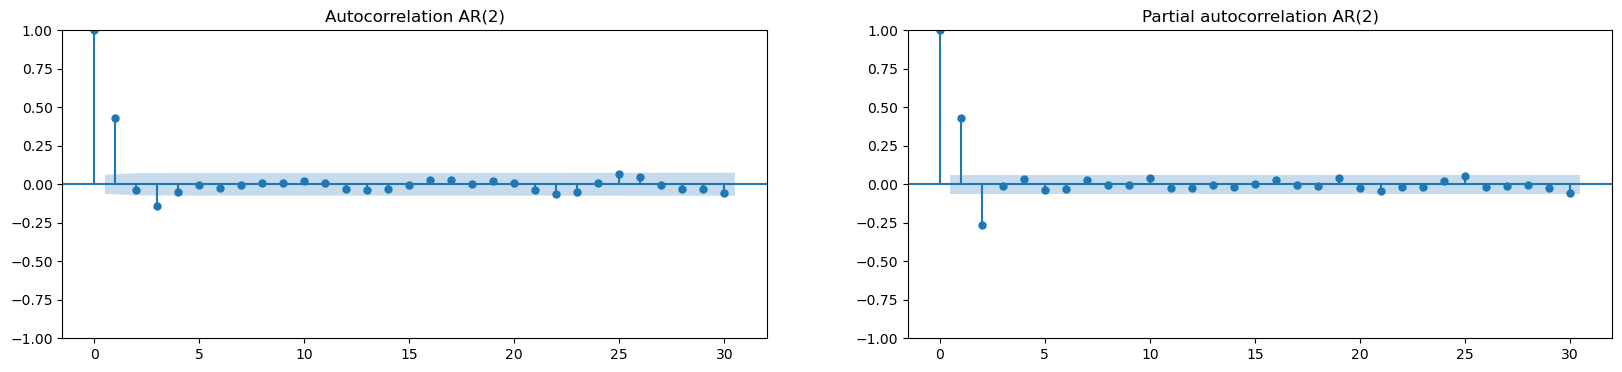

In [38]:
fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(20, 4))
_ = plot_acf(ar2, ax=ax_0, title="Autocorrelation AR(2)")
_ = plot_pacf(ar2, ax=ax_1, title="Partial autocorrelation AR(2)")

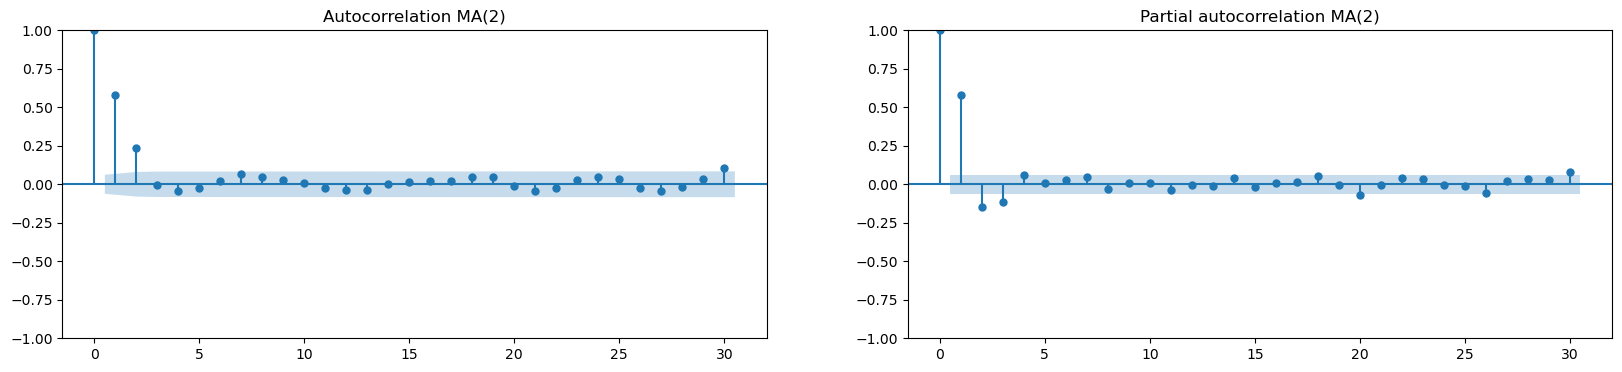

In [39]:
fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(20, 4))
_ = plot_acf(ma2, ax=ax_0, title="Autocorrelation MA(2)")
_ = plot_pacf(ma2, ax=ax_1, title="Partial autocorrelation MA(2)")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What would be a procedure to estimate the AR and MA order of a process?</p>
</div>

### Back to our problem

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot the autocorrelation and partial autocorrelation of the residual signal (without the constant and harmonic trend).</p>
</div>

Now, we fit an ARMA process on the residual signal.

In [41]:
ma_order = 7
ar_order = 8

res = ARIMA(residual_signal, order=(ar_order, 0, ma_order)).fit()
print(res.summary())

NameError: name 'residual_signal' is not defined

Using the fitted model, it is now possible to predict the value of the residual signal.

In [ ]:
in_sample_pred = res.predict()
out_sample_pred = res.forecast(n_samples_pred)

fig, ax = fig_ax()
ax.plot(time_array_train, residual_signal, label="True residual")
ax.plot(time_array_train, in_sample_pred, label="In-sample prediction")
ax.plot(time_array_pred, out_sample_pred, label="Out-of-sample prediction")
_ = plt.legend()

### Final prediction

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Make and plot the final prediction for the taxi count (not normalized) for the next two weeks, using the trend, seasonal and residual processes.</p>
    <p>What do you conclude?</p>
</div>

### Stationarity checks

As was previously seen, the residual signal was not completely stationary since it still contained seasonal and low frequency components.
To assess this intuition, several statistical tests exists. Two of the most well-known are:

- the Dickey-Fuller test (H0: the signal has a unit root); 
- the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (H0: the signal is trend/level stationary vs H1:the signal has a unit root).

Actually, they do not test for stationarity but for symptoms of non-stationarity.

In [ ]:
adf_test(residual_signal)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What can you conclude from the test?</p>
</div>

## Manage complex trend and outliers with SSA

With Singular Spectrum Analysis (SSA), it is possible to manage the low frequency trends and seasonal effects with the same procedure.
SSA is often described as a "PCA for signals".

Let $y = \{y_t\}_t$ denote a $T$-sample long univariate signal, and $L$ a window length.
The trajectory matrix $X$ is formed by  $M$ lag-shifted copies of $y$, i.e.

$$
X:=
\begin{bmatrix}
y_1&y_2&y_3&\ldots&y_{L}\\
y_2&y_3&y_4&\ldots&y_{L+1}\\
y_3&y_4&y_5&\ldots&y_{L+2}\\
\vdots&\vdots&\vdots&\ddots&\vdots
\end{bmatrix}
$$


Now, write the Singular Value Decomposition (SVD) of $X$ is as follows:

$$
X = U\Sigma V^T = \sum_{i=1}^{L} X_i\quad\text{with}\quad X_i:= \sigma_i u_i v_i^T
$$

where $\sigma=\text{diag}(\sigma_1,\dots,\sigma_L)$ are the singular values sorted in descending order, $u_i$ and $v_i$ are respectively the associated left and right singular vectors corresponding to the columns of the orthogonal matrices $U$ and $V$.
Each $X_i$ is itself a trajectory matrix.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>For a signal of length $T$ and a window of length $L$, what are the dimensions of the trajectory matrix (number of rows and columns)?</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How can you go from a trajectory matrix to a signal?</p>
</div>

Let us apply apply SSA on the signal.

In [ ]:
window_shape = 14
trajectory_matrix = get_trajectory_matrix(signal_train, window_shape)

In [ ]:
# SVD
u, eigenvals, vh = np.linalg.svd(trajectory_matrix, full_matrices=False)

NOTE: shape of signal depending on eigenvalue?

In [ ]:
plt.plot(eigenvals, "-*")

In [ ]:
ssa_decomposition = np.zeros((signal_train.size, window_shape))

for ind, (left, sigma, right) in enumerate(zip(u.T, eigenvals, vh)):
    ssa_decomposition.T[ind] = average_anti_diag(
        sigma * np.dot(left.reshape(-1, 1), right.reshape(1, -1))
    )

In [ ]:
fig, ax_arr = plt.subplots(
    nrows=window_shape // 3 + 1,
    ncols=3,
    figsize=(20, 3 * (window_shape // 3 + 1)),
)


for ind, (component, ax) in enumerate(zip(ssa_decomposition.T, ax_arr.flatten())):
    ax.plot(component)
    ax.set_xlim(0, component.size)
    ax.set_ylim(-2, 2)
    ax.set_title(f"Component n°{ind}")

In pratice, the trend (a slowly varying component), the periodic components and noise are well separated by SSA.

We can plot the successive reconstructions when adding one SSA component at a time.

In [ ]:
fig, ax_arr = plt.subplots(
    nrows=window_shape // 3 + 1,
    ncols=3,
    figsize=(20, 3 * (window_shape // 3 + 1)),
)

reconstruction = np.zeros(signal_train.size)

for component, ax in zip(ssa_decomposition.T, ax_arr.flatten()):
    reconstruction += component
    ax.plot(signal_train)
    ax.plot(reconstruction)
    ax.set_xlim(0, reconstruction.size)
    ax.set_ylim(-5, 4)

**Grouping**

Notice that several SSA components are very similar.
Usually they are summed together to deacrease the dimension of the representation.
This operation is called "grouping".

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>As in the previous tutorial, use a hierarchical clustering approach to group the SSA components together. (use the Euclidean distance and plot the associated dendogram.)</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Report the groups that you found in the <tt>groups</tt> variable.</p>
</div>

In [42]:
groups=[...]

Let us plot each SSA group individually.

In [ ]:
# grouping
grouped_ssa = np.zeros((signal_train.size, len(groups)))

for dim_ind, component_indexes in enumerate(groups):
    grouped_ssa.T[dim_ind] = np.take(ssa_decomposition, component_indexes, axis=-1).sum(
        axis=1
    )

fig, ax = fig_ax()
_ = ax.plot(grouped_ssa)

**Prediction**

The SSA components are then individually extrapolated by fitting an autoregressive model.
The extended components are summed to produce the forecast values.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Make and plot the final prediction for the taxi count (not normalized) for the next two weeks, by fitting an AR(8) process (use <tt>AutoReg(signal_train, lags=8)</tt>) to each SSA component and summing the forecasts.</p>
</div>

In [ ]:
n_samples_train

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Conclude. (Is it better or worse than the previous approach? What can we do to improve the results? What is the limitation?)</p>
</div>

# Outliers detection/removal

In [ ]:
original_calendar_time_array = X.timestamp.to_numpy()
original_taxi_count_np = X.value.to_numpy()

In [ ]:
daily_taxi_count_np = daily_taxi_count.to_numpy().squeeze()
calendar_time_array = daily_taxi_count.index.to_numpy()
n_samples = daily_taxi_count_np.size
fig, ax = fig_ax()
ax.plot(daily_taxi_count, "*-")
_ = ax.set_ylim(0)

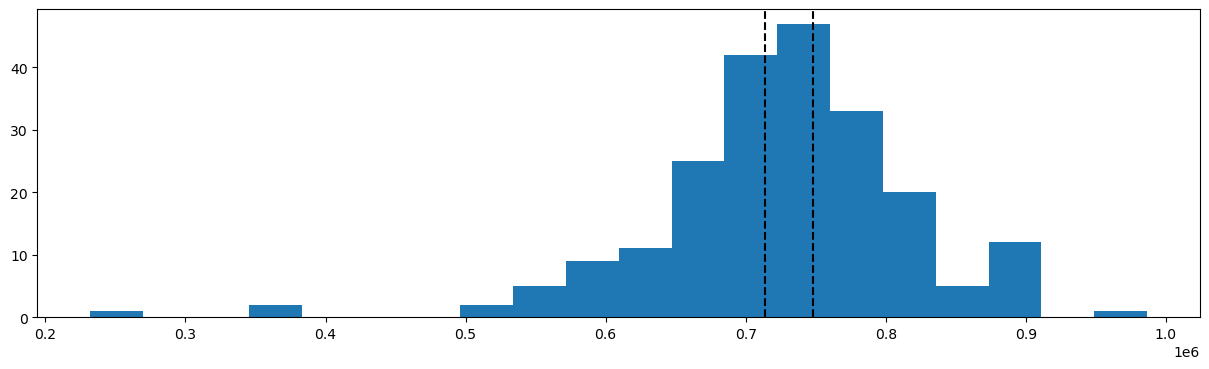

In [43]:
quantile_threshold_low, quantile_threshold_high = 0.4, 0.6

fig, ax = fig_ax()
_ = ax.hist(daily_taxi_count_np, 20)

threshold_low, threshold_high = np.quantile(
    daily_taxi_count_np, [quantile_threshold_low, quantile_threshold_high]
)

_ = ax.axvline(threshold_low, ls="--", color="k")
_ = ax.axvline(threshold_high, ls="--", color="k")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>In the previous cell, modify <tt>quantile_threshold_low</tt> and <tt>quantile_threshold_high</tt> to only exclude outliers.</p>
</div>

Plot the outliers directly on the signal.

In [ ]:
fig, ax = fig_ax()
ax.plot(calendar_time_array, daily_taxi_count_np, "*-", label="Daily taxi count")

outlier_mask = (daily_taxi_count_np < threshold_low) | (
    daily_taxi_count_np > threshold_high
)

ax.plot(
    calendar_time_array[outlier_mask],
    daily_taxi_count_np[outlier_mask],
    "*",
    label="Outliers",
)

plt.legend()
_ = ax.set_ylim(0)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Apply a median filter to remove the outliers present in the signal.</p>
</div>